In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas import Series
import requests
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

In [54]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
data = pd.DataFrame(json.loads(res.content)['Data'])
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')

# Adding weighted price

data['Weighted_Price'] = (data.close + data.high + data.low + data.open)/4

In [55]:
data.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-23,7876.50,7971.26,7478.74,7626.89,50121.07,3.867663e+08,7738.3475
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8797.14,8931.53,8680.66,8726.23,36760.97,3.232888e+08,8783.8900


In [56]:
print(f'NaN values: \n\n{data.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


In [57]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = data['Weighted_Price'].values.reshape(-1,1)
print(values[0])
values = values.astype('float32')
print(values[0])
# Transform values to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the type of the new item scaled
print(type(scaled))

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1190.865]
[1190.865]
<class 'numpy.ndarray'>
Length of the new datframe : 2001
[[0.05601164]
 [0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]]


In [58]:
scaled

array([[0.05601164],
       [0.05196624],
       [0.04434619],
       ...,
       [0.4136669 ],
       [0.43082842],
       [0.45272887]], dtype=float32)

In [60]:
# Divide data scaled data into 80% train and 40% test with overlapping
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))
test_size = int(len(scaled) * 0.4)
print("Test Size : " + str(test_size))
overlap = int(len(scaled) * 0.6)
train, test = scaled[:train_size,:], scaled[overlap:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 800
Length of training data : 1600
Length of testing data : 801


In [61]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        print('X: ', a, ', Y: ', dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [62]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

X:  [0.05601164] , Y:  0.051966235
X:  [0.05196624] , Y:  0.044346187
X:  [0.04434619] , Y:  0.03316076
X:  [0.03316076] , Y:  0.03275506
X:  [0.03275506] , Y:  0.03938658
X:  [0.03938658] , Y:  0.045155503
X:  [0.0451555] , Y:  0.044295244
X:  [0.04429524] , Y:  0.040819865
X:  [0.04081986] , Y:  0.04223512
X:  [0.04223512] , Y:  0.041712645
X:  [0.04171265] , Y:  0.04074541
X:  [0.04074541] , Y:  0.037141245
X:  [0.03714124] , Y:  0.03211189
X:  [0.03211189] , Y:  0.025503486
X:  [0.02550349] , Y:  0.026986405
X:  [0.02698641] , Y:  0.030071884
X:  [0.03007188] , Y:  0.02762787
X:  [0.02762787] , Y:  0.027685214
X:  [0.02768521] , Y:  0.029172048
X:  [0.02917205] , Y:  0.030520689
X:  [0.03052069] , Y:  0.030285183
X:  [0.03028518] , Y:  0.033579264
X:  [0.03357926] , Y:  0.035716973
X:  [0.03571697] , Y:  0.034108795
X:  [0.0341088] , Y:  0.03409926
X:  [0.03409926] , Y:  0.035453778
X:  [0.03545378] , Y:  0.035611697
X:  [0.0356117] , Y:  0.03588743
X:  [0.03588743] , Y:  0.0378042

X:  [0.00603943] , Y:  0.0056119137
X:  [0.00561191] , Y:  0.005381632
X:  [0.00538163] , Y:  0.00530313
X:  [0.00530313] , Y:  0.0056000273
X:  [0.00560003] , Y:  0.005561625
X:  [0.00556163] , Y:  0.0053472794
X:  [0.00534728] , Y:  0.005242393
X:  [0.00524239] , Y:  0.005277267
X:  [0.00527727] , Y:  0.0052982974
X:  [0.0052983] , Y:  0.005810846
X:  [0.00581085] , Y:  0.0067418986
X:  [0.0067419] , Y:  0.0066321776
X:  [0.00663218] , Y:  0.006032638
X:  [0.00603264] , Y:  0.0063081128
X:  [0.00630811] , Y:  0.0062738904
X:  [0.00627389] , Y:  0.0062802904
X:  [0.00628029] , Y:  0.0065014292
X:  [0.00650143] , Y:  0.0065781022
X:  [0.0065781] , Y:  0.0063233958
X:  [0.0063234] , Y:  0.0061475816
X:  [0.00614758] , Y:  0.0062458073
X:  [0.00624581] , Y:  0.0062064915
X:  [0.00620649] , Y:  0.0061422265
X:  [0.00614223] , Y:  0.0066502034
X:  [0.0066502] , Y:  0.0070060096
X:  [0.00700601] , Y:  0.0070812465
X:  [0.00708125] , Y:  0.007671905
X:  [0.00767191] , Y:  0.008258907
X:  [0.

X:  [0.01591292] , Y:  0.015947402
X:  [0.0159474] , Y:  0.015928723
X:  [0.01592872] , Y:  0.016067963
X:  [0.01606796] , Y:  0.016226403
X:  [0.0162264] , Y:  0.01613706
X:  [0.01613706] , Y:  0.016093303
X:  [0.0160933] , Y:  0.016330376
X:  [0.01633038] , Y:  0.01666907
X:  [0.01666907] , Y:  0.01705283
X:  [0.01705283] , Y:  0.017129634
X:  [0.01712963] , Y:  0.017171433
X:  [0.01717143] , Y:  0.01752933
X:  [0.01752933] , Y:  0.017790567
X:  [0.01779057] , Y:  0.01803234
X:  [0.01803234] , Y:  0.017636305
X:  [0.0176363] , Y:  0.017035326
X:  [0.01703533] , Y:  0.017368404
X:  [0.0173684] , Y:  0.01739492
X:  [0.01739492] , Y:  0.01733588
X:  [0.01733588] , Y:  0.017179139
X:  [0.01717914] , Y:  0.017140476
X:  [0.01714048] , Y:  0.01718776
X:  [0.01718776] , Y:  0.017138908
X:  [0.01713891] , Y:  0.017497065
X:  [0.01749706] , Y:  0.017737273
X:  [0.01773727] , Y:  0.017714022
X:  [0.01771402] , Y:  0.01779788
X:  [0.01779788] , Y:  0.017548136
X:  [0.01754814] , Y:  0.017402496

X:  [0.1129026] , Y:  0.11472304
X:  [0.11472304] , Y:  0.12915903
X:  [0.12915903] , Y:  0.1379638
X:  [0.1379638] , Y:  0.13808541
X:  [0.13808541] , Y:  0.13911141
X:  [0.13911141] , Y:  0.13792475
X:  [0.13792475] , Y:  0.13221787
X:  [0.13221787] , Y:  0.12721986
X:  [0.12721986] , Y:  0.1310952
X:  [0.1310952] , Y:  0.13781229
X:  [0.13781229] , Y:  0.13814928
X:  [0.13814928] , Y:  0.13609765
X:  [0.13609765] , Y:  0.141249
X:  [0.141249] , Y:  0.14055398
X:  [0.14055398] , Y:  0.1362996
X:  [0.1362996] , Y:  0.13840033
X:  [0.13840033] , Y:  0.14218359
X:  [0.14218359] , Y:  0.15525267
X:  [0.15525267] , Y:  0.16302723
X:  [0.16302723] , Y:  0.16696095
X:  [0.16696095] , Y:  0.17252178
X:  [0.17252178] , Y:  0.16968788
X:  [0.16968788] , Y:  0.17079644
X:  [0.17079644] , Y:  0.17922254
X:  [0.17922254] , Y:  0.19108668
X:  [0.19108668] , Y:  0.20240271
X:  [0.20240271] , Y:  0.21200646
X:  [0.21200646] , Y:  0.21275115
X:  [0.21275115] , Y:  0.21435161
X:  [0.21435161] , Y:  0.

X:  [0.18542185] , Y:  0.19757882
X:  [0.19757882] , Y:  0.20253621
X:  [0.20253621] , Y:  0.19873193
X:  [0.19873193] , Y:  0.18957345
X:  [0.18957345] , Y:  0.18289438
X:  [0.18289438] , Y:  0.1866562
X:  [0.1866562] , Y:  0.18815687
X:  [0.18815687] , Y:  0.19282272
X:  [0.19282272] , Y:  0.19842719
X:  [0.19842719] , Y:  0.20564702
X:  [0.20564702] , Y:  0.21317118
X:  [0.21317118] , Y:  0.21109371
X:  [0.21109371] , Y:  0.21690115
X:  [0.21690115] , Y:  0.22152142
X:  [0.22152142] , Y:  0.22428806
X:  [0.22428806] , Y:  0.22083658
X:  [0.22083658] , Y:  0.21678059
X:  [0.21678059] , Y:  0.21648684
X:  [0.21648684] , Y:  0.22123158
X:  [0.22123158] , Y:  0.22368316
X:  [0.22368316] , Y:  0.23007813
X:  [0.23007813] , Y:  0.23962612
X:  [0.23962612] , Y:  0.24449743
X:  [0.24449743] , Y:  0.24433272
X:  [0.24433272] , Y:  0.26161858
X:  [0.26161858] , Y:  0.28526324
X:  [0.28526324] , Y:  0.29252326
X:  [0.29252326] , Y:  0.29191342
X:  [0.29191342] , Y:  0.291709
X:  [0.291709] , Y

X:  [0.19315855] , Y:  0.19830245
X:  [0.19830245] , Y:  0.19678871
X:  [0.19678871] , Y:  0.1948856
X:  [0.1948856] , Y:  0.19621857
X:  [0.19621857] , Y:  0.20190035
X:  [0.20190035] , Y:  0.20653379
X:  [0.20653379] , Y:  0.20588632
X:  [0.20588632] , Y:  0.20532922
X:  [0.20532922] , Y:  0.1953715
X:  [0.1953715] , Y:  0.18558553
X:  [0.18558553] , Y:  0.18497749
X:  [0.18497749] , Y:  0.18213208
X:  [0.18213208] , Y:  0.18382347
X:  [0.18382347] , Y:  0.18501706
X:  [0.18501706] , Y:  0.18424708
X:  [0.18424708] , Y:  0.1846456
X:  [0.1846456] , Y:  0.18500726
X:  [0.18500726] , Y:  0.18737513
X:  [0.18737513] , Y:  0.18425268
X:  [0.18425268] , Y:  0.18024607
X:  [0.18024607] , Y:  0.18036036
X:  [0.18036036] , Y:  0.18121958
X:  [0.18121958] , Y:  0.18101321
X:  [0.18101321] , Y:  0.18094593
X:  [0.18094593] , Y:  0.18233259
X:  [0.18233259] , Y:  0.18030082
X:  [0.18030082] , Y:  0.17650972
X:  [0.17650972] , Y:  0.17279282
X:  [0.17279282] , Y:  0.17365818
X:  [0.17365818] , Y

In [63]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [64]:
print(trainX)
#print(trainY)

[[[0.05601164]]

 [[0.05196624]]

 [[0.04434619]]

 ...

 [[0.41526136]]

 [[0.42417052]]

 [[0.442697  ]]]


In [65]:
# Initialise the sequential model
model = Sequential()
# Add the LSTM hidden layer with 100 nodes
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dropout(0.2))
# Add the output layer
model.add(Dense(1))
# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')
# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

print()

Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 1s 806us/step - loss: 0.0795 - val_loss: 0.2652
Epoch 2/300
1599/1599 [==============================] - 0s 35us/step - loss: 0.0779 - val_loss: 0.2575
Epoch 3/300
1599/1599 [==============================] - 0s 34us/step - loss: 0.0751 - val_loss: 0.2529
Epoch 4/300
1599/1599 [==============================] - 0s 37us/step - loss: 0.0714 - val_loss: 0.2411
Epoch 5/300
1599/1599 [==============================] - 0s 35us/step - loss: 0.0695 - val_loss: 0.2327
Epoch 6/300
1599/1599 [==============================] - 0s 34us/step - loss: 0.0669 - val_loss: 0.2232
Epoch 7/300
1599/1599 [==============================] - 0s 35us/step - loss: 0.0637 - val_loss: 0.2120
Epoch 8/300
1599/1599 [==============================] - 0s 35us/step - loss: 0.0608 - val_loss: 0.2010
Epoch 9/300
1599/1599 [==============================] - 0s 34us/step - loss: 0.0571 - val_loss: 0.1879
Epoch 10/300
159

1599/1599 [==============================] - 0s 39us/step - loss: 0.0065 - val_loss: 0.0093
Epoch 79/300
1599/1599 [==============================] - 0s 40us/step - loss: 0.0105 - val_loss: 0.0094
Epoch 80/300
1599/1599 [==============================] - 0s 37us/step - loss: 0.0058 - val_loss: 0.0090
Epoch 81/300
1599/1599 [==============================] - 0s 37us/step - loss: 0.0060 - val_loss: 0.0085
Epoch 82/300
1599/1599 [==============================] - 0s 33us/step - loss: 0.0062 - val_loss: 0.0088
Epoch 83/300
1599/1599 [==============================] - 0s 39us/step - loss: 0.0074 - val_loss: 0.0096
Epoch 84/300
1599/1599 [==============================] - 0s 38us/step - loss: 0.0107 - val_loss: 0.0094
Epoch 85/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0075 - val_loss: 0.0114
Epoch 86/300
1599/1599 [==============================] - 0s 39us/step - loss: 0.0065 - val_loss: 0.0089
Epoch 87/300
1599/1599 [==============================] - 0s 40us/st

1599/1599 [==============================] - 0s 35us/step - loss: 0.0050 - val_loss: 0.0084
Epoch 156/300
1599/1599 [==============================] - 0s 38us/step - loss: 0.0048 - val_loss: 0.0085
Epoch 157/300
1599/1599 [==============================] - 0s 36us/step - loss: 0.0055 - val_loss: 0.0084
Epoch 158/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0057 - val_loss: 0.0085
Epoch 159/300
1599/1599 [==============================] - 0s 39us/step - loss: 0.0054 - val_loss: 0.0085
Epoch 160/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0062 - val_loss: 0.0089
Epoch 161/300
1599/1599 [==============================] - 0s 39us/step - loss: 0.0067 - val_loss: 0.0106
Epoch 162/300
1599/1599 [==============================] - 0s 37us/step - loss: 0.0066 - val_loss: 0.0090
Epoch 163/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0072 - val_loss: 0.0098
Epoch 164/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 44us/step - loss: 0.0058 - val_loss: 0.0091
Epoch 233/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0055 - val_loss: 0.0084
Epoch 234/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0047 - val_loss: 0.0084
Epoch 235/300
1599/1599 [==============================] - 0s 37us/step - loss: 0.0051 - val_loss: 0.0088
Epoch 236/300
1599/1599 [==============================] - 0s 37us/step - loss: 0.0052 - val_loss: 0.0087
Epoch 237/300
1599/1599 [==============================] - 0s 36us/step - loss: 0.0060 - val_loss: 0.0084
Epoch 238/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 239/300
1599/1599 [==============================] - 0s 36us/step - loss: 0.0050 - val_loss: 0.0092
Epoch 240/300
1599/1599 [==============================] - 0s 34us/step - loss: 0.0052 - val_loss: 0.0087
Epoch 241/300
1599/1599 [==============================] - 0

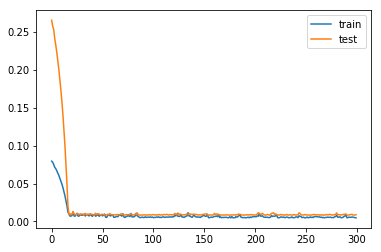

In [66]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

(800, 1)
[0.05194486]


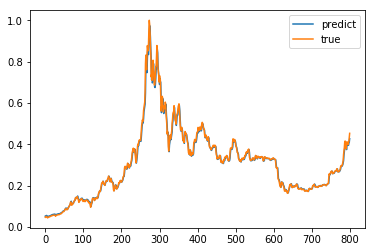

In [67]:
yhat = model.predict(testX) # Here yhat is the predicted value from the test set (y_pred)
print(yhat.shape)
print(yhat[0])

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [68]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1113.0284]
[1006.24]


In [71]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 296.077


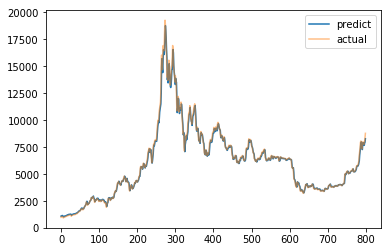

In [72]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

# Nedenunder er sjov og ballade - det har ikke ført til det ønskede og bør bare ignoreres for nu!

In [95]:
Xtest = testX

In [96]:
x = np.zeros((1,1,1))
x[[0]] = yhat[len(yhat)-1][0]
preds = []
#model.reset_states()
for i in range(120):
    yklat = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    #print(yklat)
    preds.append(yklat[0][0])
    #print('X: ', x, ', Y: ', yklat)
    #print(yklat[len(yklat)-1][0])
    y = np.zeros((1,1,1))
    y[[0]] = yklat[len(yklat)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)
    #x[[0]] = yklat[0][0]
    
    #model.reset_states()
    
print(yklat.shape)
print(yklat[0])
print(yklat)

(919, 1)
[0.05194486]
[[0.05194486]
 [0.05115772]
 [0.05252685]
 [0.05513996]
 [0.0544721 ]
 [0.05293239]
 [0.05008357]
 [0.04820144]
 [0.04940033]
 [0.05116116]
 [0.05304503]
 [0.05278949]
 [0.05279052]
 [0.05389656]
 [0.05511758]
 [0.05550879]
 [0.05717657]
 [0.05812118]
 [0.05752191]
 [0.0591125 ]
 [0.06042189]
 [0.06019986]
 [0.06068397]
 [0.06127556]
 [0.06168314]
 [0.06185241]
 [0.06047377]
 [0.05988131]
 [0.05580746]
 [0.05984838]
 [0.06033275]
 [0.06107705]
 [0.06143897]
 [0.06241846]
 [0.06330438]
 [0.06308842]
 [0.06316523]
 [0.06340968]
 [0.06392832]
 [0.06512157]
 [0.06675584]
 [0.06745122]
 [0.06767306]
 [0.06809345]
 [0.070668  ]
 [0.07281198]
 [0.07439224]
 [0.07690309]
 [0.07751882]
 [0.07777026]
 [0.07841156]
 [0.08186831]
 [0.08568487]
 [0.08748781]
 [0.09126738]
 [0.0886129 ]
 [0.08665079]
 [0.08995965]
 [0.08791994]
 [0.08702385]
 [0.08998854]
 [0.09478108]
 [0.09776127]
 [0.10167118]
 [0.10376411]
 [0.10723571]
 [0.11184783]
 [0.1205624 ]
 [0.12395946]
 [0.11727142

In [83]:
yklat

array([[0.05194486],
       [0.05115772],
       [0.05252685],
       ...,
       [0.24474016],
       [0.2447397 ],
       [0.24473923]], dtype=float32)

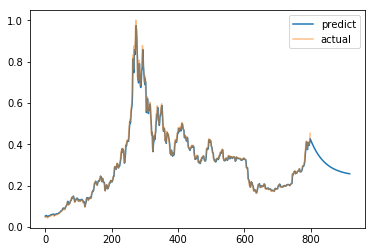

In [97]:
pyplot.plot(yklat, label='predict')
pyplot.plot(testY, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()